# RARAS - Descriptive analysis of the Retrospective study

## Config and load data

In [1]:
# Pandas configuration
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

# Plot configuration
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns
FONT_PATH = 'assets/font/Lato-Regular.ttf'
font_manager.fontManager.addfont(FONT_PATH)
prop = font_manager.FontProperties(fname=FONT_PATH)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

# Terminal colors
R = '\033[0m'
C = '\033[1;36m'
Y = '\033[1m\033[38;5;220m'

# Custom functions
from scripts.functions import custom_value_counts, create_descriptive_table, create_disease_count

# Apply the decorator to the original value_counts method
pd.Series.value_counts = custom_value_counts(pd.Series.value_counts)
pd.DataFrame.value_counts = custom_value_counts(pd.DataFrame.value_counts)

# Load files
id_df = pd.read_csv('data/identification.csv')
diag_df = pd.read_csv('data/diagnostic.csv')
trat_df = pd.read_csv('data/treatment.csv')
trat_type_df = pd.read_csv('data/treatment_type.csv')
followup_df = pd.read_csv('data/follow_up.csv')

# Create masks
confirmed_diag_mask = diag_df['diagnostic_status'] == 'Confirmed diagnosis'
suspect_diag_mask = diag_df['diagnostic_status'] == 'Suspected diagnosis'
undiagnosed_mask = diag_df['diagnostic_status'] == 'Undiagnosed'

id_df.shape, diag_df.shape, trat_df.shape, trat_type_df.shape, followup_df.shape

((12269, 18), (12261, 20), (11871, 9), (9561, 9), (12269, 11))

## Identification features

In [2]:
print(f'{C}Identification form preview:{R}')
display(id_df.head())

print(f'{C}Total participants:{R}', id_df['record_id'].nunique())
print(f'{C}Total of centers:{R}', id_df['center_id'].nunique())
print(f'{C}Total of cities of birth:{R}', id_df['birth_city'].nunique())
print(f'{C}Number of record_ids in more than one center_id:{R}', 86)
# df = pd.read_csv('scripts/original_data/identificacao.csv')
# df = df[df['project_id']==17]
# df.groupby('nome')['id_centro'].nunique().value_counts()

Identification form preview:


,record_id,center_id,revised_consultation_date,first_consultation_date_center,first_consultation_date_specialty,birth_date,age,color_or_race,sex,birth_city,birth_region,birth_country,residence_region,residence_city,age_at_first_evaluation_at_center,age_at_first_evaluation_at_specialty,length_of_follow_up_at_center,length_of_follow_up_at_specialty
0,1,1,2018-01-04,2010-05-27,2010-05-27,1993-10-07,24.24,White,Female,Sapiranga - RS,South,NaN,South,Nova Hartz - RS,16.64,16.64,7.61,7.61
1,2,1,2018-01-09,2000-05-18,2000-08-30,1956-07-01,61.52,White,Female,Porto Alegre - RS,South,NaN,South,Porto Alegre - RS,43.88,44.16,17.65,17.36
2,3,1,2018-01-09,2007-09-24,2007-09-24,1984-03-04,33.85,White,Female,São Francisco de Paula - RS,South,NaN,South,Parobé - RS,23.56,23.56,10.29,10.29
3,4,1,2018-01-11,2004-08-20,2004-08-20,1984-05-10,33.67,White,Female,Ibiraiaras - RS,South,NaN,South,Porto Alegre - RS,20.28,20.28,13.39,13.39
4,5,1,2018-01-11,2014-10-20,NaN,2001-11-01,16.19,White,Female,Bento Gonçalves - RS,South,NaN,South,Bento Gonçalves - RS,12.97,NaN,3.23,NaN


Total participants: 12269
Total of centers: 34
Total of cities of birth: 1723
Number of record_ids in more than one center_id: 86


## Diagnostic features

In [3]:
print(f'{C}Diagnostic form preview:{R}')
display(diag_df.head())

print(f"{C}Number of symptoms mean:{R} {diag_df['symptoms'].dropna().str.split(', ').apply(len).mean():.2f}")
print(f'{C}Number of confirmed diagnoses, grouped by participant{R}')
print(
    diag_df
    [confirmed_diag_mask]
    .groupby('record_id')
    ['diagnostic_status'].count().value_counts()
    .reset_index()
    .rename(columns={
        'index': 'N diagnoses',
        'diagnostic_status': 'N participants'
    })
    .to_string(index=False)
)

print(f'{C}Type of diagnostic distribution{R}')
print(diag_df[confirmed_diag_mask]['diagnostic_type']
 .dropna().apply(lambda x: x.split(' ')[0])
 .value_counts(total=True, ascending=False).to_string())

print(f'{C}Etiological diagnostic distribution, among confirmed diagnoses{R}')
_mask = diag_df['diagnostic_type'].str.contains('Etiologic').fillna(False)
print(diag_df[_mask & confirmed_diag_mask]['diagnostic_type'].value_counts(total=True, ascending=False).to_string())
print(f'{C}Most common disorders, by ORPHA code:{R}')
print(diag_df[confirmed_diag_mask]['disease_orpha'].value_counts().head().to_string())

diseases_columns = ['disease_orpha', 'disease_omim', 'disease_cid10']
total = diag_df[diseases_columns].notna().sum().sum()
print(f'{C}Terminologies{R}')
for name, col in zip(['ORPHA', 'OMIM', 'CID10'], diseases_columns):
    print(name, '\t', disease_sum := diag_df[col].notna().sum(), '\t', f"({disease_sum / total * 100:.2f}%)")
    
print('Most common disorders, excluding newborn screening')
_mask = diag_df['diagnostic_moment'] != 'Newborn screening'
s = create_disease_count(diag_df[_mask][['disease_orpha', 'disease_omim', 'disease_cid10']])
display(s.to_frame())

Diagnostic form preview:


,record_id,center_id,instance_id,diagnostic_status,disease_cid10,disease_orpha,disease_omim,diagnostic_payer_source,diagnostic_moment,diagnostic_date,symptoms,family_recurrence,consanguinity,age_at_symptoms_onset_days,diagnostic_type,maternal_age_at_birth,paternal_age_at_birth,age_at_symptoms_onset,age_at_diagnosis,diagnostic_odyssey
0,1,1,1,Confirmed diagnosis,NaN,"110, Síndrome de Bardet-Biedl",NaN,NaN,Postnatal,2010-05-27,"HP:0001830, HP:0001956, HP:0002514",Yes,No,0.00,Clinical,NaN,NaN,0.00,16.64,16.64
1,2,1,1,Confirmed diagnosis,NaN,"355, Doença de Gaucher (termo genérico)",NaN,Pesquisa clínica,Postnatal,NaN,"HP:0004859, HP:0001744, HP:0001903",No,No,10950.00,Molecular (Etiological),NaN,NaN,29.98,NaN,NaN
2,3,1,1,Confirmed diagnosis,NaN,"273, Distrofia miotónica de Steinert",NaN,NaN,Postnatal,NaN,"HP:0002058, HP:0020034",Yes,No,7300.00,Molecular (Etiological),NaN,26.00,19.99,NaN,NaN
3,4,1,1,Confirmed diagnosis,NaN,"579, Mucopolissacaridose tipo 1 (MPS1)",NaN,SUS,Postnatal,2004-10-01,"HP:0010535, HP:0007957, HP:0002828, HP:0000280...",No,No,2190.00,Biochemical (Etiological),24.00,27.00,6.00,20.39,20.38
4,5,1,1,Confirmed diagnosis,NaN,"315306, Hiperplasia adrenal congénita classica...",NaN,SUS,Newborn screening,NaN,"HP:0001007, HP:0000062",No,No,0.00,Biochemical (Etiological),NaN,NaN,0.00,NaN,NaN


Number of symptoms mean: 2.83
Number of confirmed diagnoses, grouped by participant
 N diagnoses  N participants
           1            7667
           2              65
           3               2
Type of diagnostic distribution
                        n     %
Clinical             2767 36.34
Biochemical          2067 27.14
Molecular            1497 19.66
Cytogenetic           613  8.05
Anatomopathological   588  7.72
Etiological            83  1.09
Etiological diagnostic distribution, among confirmed diagnoses
                                      n     %
Biochemical (Etiological)          2067 42.64
Molecular (Etiological)            1496 30.86
Cytogenetic (Etiological)           613 12.65
Anatomopathological (Etiological)   588 12.13
Etiological                          83  1.71
Most common disorders, by ORPHA code:
716, Fenilcetonúria                         530
98896, Distrofia muscular, tipo Duchenne    202
803, Esclerose lateral amiotrófica (ELA)    159
442, Hipotiroidismo con

n
Phenylketonuria (n=166)         orpha 716                                           135
                                omim 261600                                          24
                                cid10 E70.0                                           7
Cystic Fibrosis (n=383)         cid10 E84.9                                         150
                                cid10 E84.0                                          81
                                orpha 586                                            74
                                cid10 E84.8                                          66
                                cid10 E84.1                                           9
                                omim 219700                                           3
Acromegaly (n=375)              cid10 E22.0                                         277
                                orpha 963                                            98
Osteogenesis Imperfecta (n=352) cid10 Q78.0                                         174
                                orpha 666                                            58
                                orpha 216796                                         55
                                orpha 216820                                         33
                                orpha 216812                                         23
                                orpha 2771                                            3
                                omim 610682 - 610915 - 610967 - 610968 - 613848...    3
                                orpha 216804                                          1
                                orpha 216828                                          1
                                omim 610967                                           1

## Treatment features


In [4]:
print(f'{C}Treatment form preview:{R}')
display(trat_df.head())
display(trat_type_df.head())

Treatment form preview:


,record_id,center_id,instance_id,treatment_related_to_rare_disease,diag_instance_id,follows_other_specialty,other_specialty,medical_specialty,all_specialties
0,1,1,1,Related to rare disease,1.00,Yes,NaN,nefrologia,nefrologia
1,2,1,1,Related to rare disease,1.00,No,NaN,NaN,NaN
2,3,1,1,Related to rare disease,1.00,Yes,"nutricao, ginecologia, pneumologia, enfermagem...","neurologia, oftalmologia","neurologia, oftalmologia, nutricao, ginecologi..."
3,4,1,1,Related to rare disease,1.00,Yes,NaN,"cardiologia, dermatologia, oftalmologia, otorr...","cardiologia, dermatologia, oftalmologia, otorr..."
4,5,1,1,Related to rare disease,1.00,Yes,cirurgia pediatrica,endocrinologia,"endocrinologia, cirurgia pediatrica"


,record_id,center_id,instance_id,treatment_start_date,treatment_payer_source,treatment_type,description,data_nascimento,age_at_treatment_start
0,7,1,1,NaN,sus,Diet therapy,NaN,2010-02-22,NaN
1,8,1,1,NaN,sus,Diet therapy,NaN,1997-10-12,NaN
2,9,1,1,NaN,sus,Diet therapy,NaN,1995-10-20,NaN
3,11,1,1,2017-09-01,sus,Diet therapy,NaN,2016-08-10,1.06
4,18,1,1,2013-07-30,sus,Diet therapy,NaN,2013-07-16,0.04


## Hospitalization and deaths

In [5]:
print(f'{C}Follow-up form preview:{R}')
display(followup_df.head())

death_count = followup_df['death'].map({'Yes': True, 'No': False}).sum()
hospitalization_count = followup_df['previous_hospitalization'].map({'Yes': True, 'No': False}).sum()
autopsy_count = followup_df['autopsy_performed'].map({'Yes': True, 'No': False}).sum()
print(f'{C}Number of deaths:{R}', death_count, 
      f"({death_count / followup_df['record_id'].nunique() * 100:.2f}%)")

print(f'{C}Number of hospitalizations:{R}', hospitalization_count, 
      f"({hospitalization_count / followup_df['record_id'].nunique() * 100:.2f}%)")

print(f'{C}Number of autopsies:{R}', autopsy_count,
        f"({autopsy_count / followup_df['autopsy_performed'].dropna().size * 100:.2f}%)")

Follow-up form preview:


,record_id,center_id,number_of_hospitalizations,hospitalization_date,cid10_hospitalization,previous_hospitalization,death_date,age_at_death,autopsy_performed,cid10_death,death
0,1,1,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,No
1,2,1,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,No
2,3,1,7.00,2019-10-11,J18.0,Yes,NaN,NaN,NaN,NaN,No
3,4,1,6.00,2016-04-03,NaN,Yes,NaN,NaN,NaN,NaN,No
4,5,1,1.00,2019-08-01,N82.1,Yes,NaN,NaN,NaN,NaN,No


Number of deaths: 172 (1.40%)
Number of hospitalizations: 4885 (39.82%)
Number of autopsies: 18 (14.17%)


--- 
## Categorical features

In [6]:
# Select categorical features
id_categorical_columns = ['color_or_race', 'sex', 'birth_region', 'residence_region']
diag_categorical_columns = ['diagnostic_status', 'diagnostic_payer_source', 
                            'diagnostic_moment', 'family_recurrence', 'consanguinity', 
                            'diagnostic_type']
trat_categorical_columns = ['treatment_related_to_rare_disease', 'follows_other_specialty']
trat_type_categorical_columns = ['treatment_type', 'treatment_payer_source']
followup_categorical_columns = ['previous_hospitalization', 'death', 'autopsy_performed']

pd.concat([
    create_descriptive_table(id_df, id_categorical_columns),
    create_descriptive_table(diag_df, diag_categorical_columns),
    create_descriptive_table(trat_df, trat_categorical_columns),
    create_descriptive_table(trat_type_df, trat_type_categorical_columns),
    create_descriptive_table(followup_df, followup_categorical_columns),
])

n  \
feature                           value                                                   
Color or race                     Brown                                            5013   
                                  White                                            4847   
                                  Black                                             606   
                                  Yellow                                             68   
                                  Indigenous                                         30   
Sex                               Female                                           6198   
                                  Male                                             6053   
                                  Undetermined                                       13   
Birth region                      Southeast                                        3731   
                                  Northeast                                        3713   
                                  South                                            1657   
                                  North                                             666   
                                  Born in other countries                            12   
Residence region                  Southeast                                        3960   
                                  Northeast                                        3935   
                                  South                                            2080   
                                  North                                             637   
Diagnostic status                 Confirmed diagnosis                              7803   
                                  Suspected diagnosis                              2299   
                                  Undiagnosed                                      2159   
Diagnostic payer source           SUS                                              3791   
                                  Rede de apoio ao diagnóstico                      186   
                                  Pesquisa clínica                                  173   
                                  Programa diagnóstico da industria farmaceutica    125   
                                  Financiamento próprio                             117   
                                  Saude suplementar                                  97   
                                  Judicial                                           16   
Diagnostic moment                 Postnatal                                        8735   
                                  Newborn screening                                 932   
                                  Prenatal                                          117   
Family recurrence                 No                                               7730   
                                  Yes                                              2682   
Consanguinity                     No                                               8803   
                                  Yes                                               792   
Diagnostic type                   Clinical                                         4657   
                                  Biochemical (Etiological)                        2159   
                                  Molecular (Etiological)                          1554   
                                  Cytogenetic (Etiological)                         675   
                                  Anatomopathological (Etiological)                 653   
                                  Etiological                                        97   
                                  Molecular (Clinical)                                1   
Treatment related to rare disease Related to rare disease                          6430   
                                  Not related to rare disease                     

--- 
## Numerical features

In [7]:
# Select numeric features
id_numeric_columns = ['age', 'age_at_first_evaluation_at_center', 'age_at_first_evaluation_at_specialty', 
                      'length_of_follow_up_at_center', 'length_of_follow_up_at_specialty']
diag_numeric_columns = ['diagnostic_odyssey', 'age_at_symptoms_onset', 'maternal_age_at_birth', 'paternal_age_at_birth']
type_trat_numeric_columns_map = {
    'Diet therapy': 'diet_age_treatment_start',
    'Drug therapy': 'drug_age_treatment_start',
    'Other': 'other_age_treatment_start',
    'Rehabilitation': 'rehab_age_treatment_start',
}

In [8]:
print(f'{C}All diagnostic status:{R}')

pd.concat([
    id_df[id_numeric_columns].describe(),
    diag_df[diag_numeric_columns].describe(),
    followup_df.dropna(subset='number_of_hospitalizations').groupby('record_id')['number_of_hospitalizations'].sum().describe(),
    followup_df['age_at_death'].describe(),
    trat_type_df.groupby('treatment_type')['age_at_treatment_start'].describe().T.rename(columns=type_trat_numeric_columns_map)
], axis=1).T

All diagnostic status:


,count,mean,std,min,25%,50%,75%,max
age,12222.00,19.60,19.33,0.00,4.89,12.74,28.77,95.76
age_at_first_evaluation_at_center,11595.00,14.59,18.72,0.00,0.90,6.26,20.81,95.68
age_at_first_evaluation_at_specialty,11328.00,15.28,18.85,0.00,1.39,7.29,21.47,95.07
length_of_follow_up_at_center,11619.00,5.33,6.33,0.00,0.58,2.76,7.93,47.93
length_of_follow_up_at_specialty,11252.00,4.07,5.68,0.00,0.15,1.73,5.36,47.93
diagnostic_odyssey,5030.00,17.75,19.81,0.00,1.99,8.99,30.02,88.73
age_at_symptoms_onset,9272.00,9.19,16.63,0.00,0.00,0.82,8.99,87.94
maternal_age_at_birth,4812.00,27.71,7.06,12.00,22.00,27.00,33.00,63.00
paternal_age_at_birth,3975.00,31.72,8.39,12.00,25.00,31.00,37.00,79.00
number_of_hospitalizations,4303.00,4.15,14.20,0.00,1.00,2.00,3.00,379.00


In [9]:
print(f'{C}Only confirmed diagnoses:{R}')

_record_id_mask = diag_df[confirmed_diag_mask]['record_id'].unique()

pd.concat([
    id_df[id_df['record_id'].isin(_record_id_mask)][id_numeric_columns].describe(),
    diag_df[diag_df['record_id'].isin(_record_id_mask)][diag_numeric_columns].describe(),
    followup_df[followup_df['record_id'].isin(_record_id_mask)]
        .groupby('record_id')['number_of_hospitalizations'].sum().describe(),
    trat_type_df[trat_type_df['record_id'].isin(_record_id_mask)]
        .groupby('treatment_type')['age_at_treatment_start'].describe().T.rename(columns=type_trat_numeric_columns_map),
], axis=1).T

Only confirmed diagnoses:


,count,mean,std,min,25%,50%,75%,max
age,7725.00,22.16,20.08,0.00,6.07,15.16,34.44,88.97
age_at_first_evaluation_at_center,7388.00,16.19,19.64,0.00,0.75,7.33,26.85,86.85
age_at_first_evaluation_at_specialty,7059.00,16.72,19.76,0.00,1.11,8.15,27.66,88.97
length_of_follow_up_at_center,7388.00,6.19,6.70,0.00,1.00,3.76,9.47,47.93
length_of_follow_up_at_specialty,7002.00,5.10,6.23,0.00,0.61,2.76,7.30,47.93
diagnostic_odyssey,4129.00,18.44,20.10,0.00,2.00,9.56,31.96,88.73
age_at_symptoms_onset,5945.00,10.99,17.89,0.00,0.00,1.00,13.99,87.94
maternal_age_at_birth,2595.00,27.70,7.11,12.00,22.00,27.00,33.00,63.00
paternal_age_at_birth,2144.00,31.72,8.37,12.00,25.00,31.00,37.00,68.00
number_of_hospitalizations,7734.00,1.87,10.67,0.00,0.00,0.00,1.00,379.00


## Statistical Associations

--- 
# Annex

## Figure 1.a
Histogram of Age and Sex Distribution of Participants

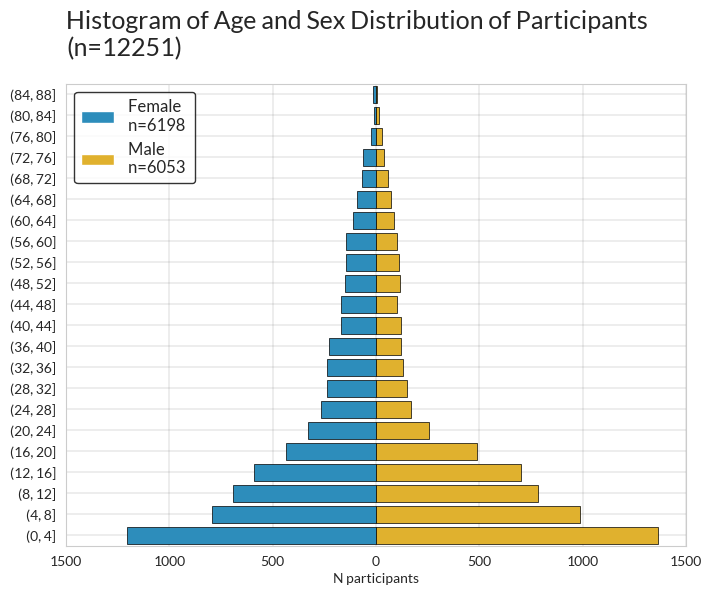

In [10]:
# Feature: age range
id_df['age_range'] = pd.cut(
    id_df['age'],
    bins=list(range(0, 92, 4))
)

# Generate plot data
plot_data = (
    pd.concat([
        id_df
        [id_df['sex'] == i]
        [['age_range', 'age']]
        .groupby('age_range')
        .agg('count')
        .rename(columns={'age': f'{i}'})
    for i in ['Female', 'Male']
    ], axis=1)
    # Multiply Female by -1 to invert the axis
    .assign(Female=lambda x: x['Female'] * -1)
    .melt(ignore_index=False)
    .reset_index()
)
del id_df['age_range']
# Create pyramid plot
plt.figure(figsize=(8, 6))

fig = sns.barplot(
    data=plot_data, x='value', y='age_range',
    hue='variable', orient='horizontal',
    palette=['#1696d2', '#fdbf11'],
    dodge=False
)
fig.invert_yaxis()
fig.set_xlabel('N participants')
fig.set_ylabel(None)
# Modify legend to add number of observations
handles, labels = fig.get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=[f"{l} \nn={id_df[id_df['sex'] == l].shape[0]} " for l in labels],
    title=None,
    loc='upper left',
    fontsize=12,
    edgecolor='black',
    framealpha=.8,
)
# Add edge bar color
for _, bar in enumerate(fig.patches):
    bar.set_edgecolor('black')
    bar.set_linewidth(.5)

fig.set_xticks(fig.get_xticks())
fig.set_xticklabels([f'{abs(x):.0f}' for x in fig.get_xticks()])
n_size = id_df['sex'].isin(['Male', 'Female']).sum()
plt.title(f'Histogram of Age and Sex Distribution of Participants\n(n={n_size})', fontsize=18, pad=20, loc='left')
plt.grid(True, color='gray', linewidth=.2)
# Save image
plt.savefig('assets/plots/figure_1a.png', dpi=300, bbox_inches='tight')

plt.show()

## Figure 1.b

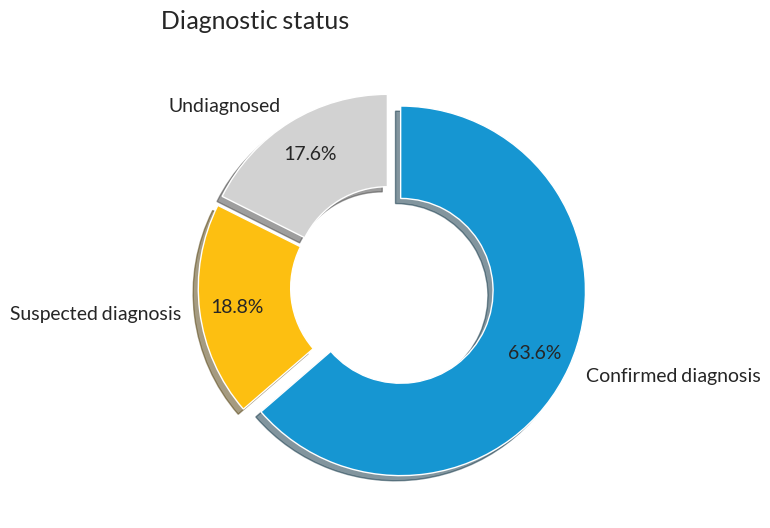

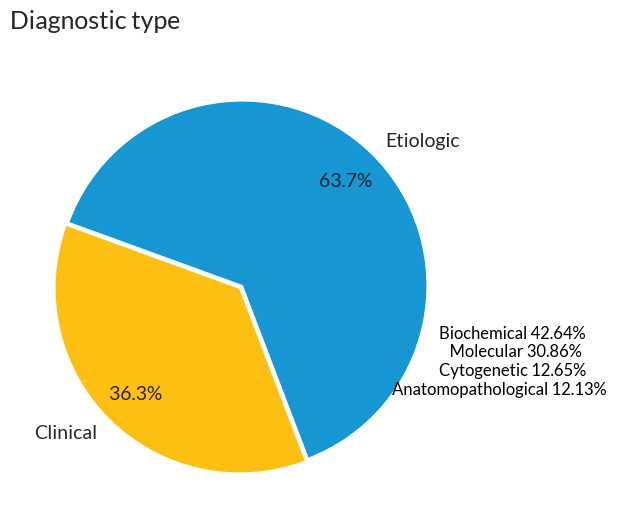

In [11]:
# Pie plot for diagnostic status and type of diagnostic

# Create plot data
plot_data = (
    diag_df
    ['diagnostic_status']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'Diagnostic status', 'diagnostic_status': 'N'})
)

# Create pie plot
plt.figure(figsize=(8, 6))
plt.pie(
    plot_data['N'],
    labels=plot_data['Diagnostic status'],
    autopct='%1.1f%%',
    colors=['#1696d2', '#fdbf11', '#d2d2d2'],
    wedgeprops=dict(width=.5, edgecolor='w'),
    textprops=dict(fontsize=14),
    pctdistance=.8,
    startangle=90,
    explode=[.05, .05, .05],
    shadow=True,
    counterclock=False,
)
plt.title('Diagnostic status', fontsize=18, pad=20, loc='left')
# Save image
plt.savefig('assets/plots/figure_1b_diagnostic_status.png', dpi=300, bbox_inches='tight')
plt.show()

# Create plot data

def _match_diag_type(x):
    if 'Clinical' in x:
        return 'Clinical'
    elif 'Etiologic' in x:
        return 'Etiologic'
    else:
        return None
    
plot_data = (
diag_df[confirmed_diag_mask]['diagnostic_type']
# Match only if Clinical or Etiologic is in the string
.dropna().apply(_match_diag_type)
.value_counts()
.reset_index()
.rename(columns={'index': 'Diagnostic type', 'diagnostic_type': 'N'})
)

# Create pie plot
plt.figure(figsize=(8, 6))
plt.pie(
    plot_data['N'],
    labels=plot_data['Diagnostic type'],
    autopct='%1.1f%%',
    colors=['#1696d2', '#fdbf11'],
    textprops=dict(fontsize=14),
    pctdistance=.8,
    explode=[.01, .01],
    startangle=160,
    counterclock=False,
)
# Annotation data
_mask = diag_df['diagnostic_type'].str.contains('Etiologic').fillna(False)
annot_data = (
    diag_df[_mask & confirmed_diag_mask]['diagnostic_type']
    .value_counts(total=True, ascending=False)
    .reset_index()
    .assign(annot=lambda x: x['index'].str.split(' ').str[0]
            + ' ' + x['%'].round(2).astype(str) + '%')
    ['annot'].head(4).to_string(index=False)
)
# Add annotation on side of Etiologic slice
plt.annotate(
    annot_data,
    xy=(1, 0.5),
    xytext=(1.4, -.4),
    xycoords='data',
    textcoords='data',
    ha='center',
    va='center',
    fontsize=12,
    color='black',

)

plt.title('Diagnostic type', fontsize=18, pad=20, loc='left')
# Save image
plt.savefig('assets/plots/figure_1b_diagnostic_type.png', dpi=300, bbox_inches='tight')
plt.show()

## Table 1
Sample characterization

In [12]:
df = create_descriptive_table(id_df, ['color_or_race', 'sex', 'birth_region', 'residence_region'])
display(df)

n     %
feature          value                              
Color or race    Brown                    5013 47.45
                 White                    4847 45.88
                 Black                     606  5.74
                 Yellow                     68  0.64
                 Indigenous                 30  0.28
Sex              Female                   6198 50.54
                 Male                     6053 49.36
                 Undetermined               13  0.11
Birth region     Southeast                3731 38.15
                 Northeast                3713 37.97
                 South                    1657 16.94
                 North                     666  6.81
                 Born in other countries    12  0.12
Residence region Southeast                3960 37.32
                 Northeast                3935 37.08
                 South                    2080 19.60
                 North                     637  6.00

## Table 2
Most frequent diagnoses in RARAS and applied coding

In [13]:
s = create_disease_count(diag_df[['disease_orpha', 'disease_omim', 'disease_cid10']])
display(s.to_frame())

n
Phenylketonuria (n=623)         orpha 716                                           533
                                cid10 E70.0                                          57
                                omim 261600                                          30
                                cid10 E70.1                                           3
Cystic Fibrosis (n=495)         cid10 E84.9                                         182
                                orpha 586                                           124
                                cid10 E84.0                                          89
                                cid10 E84.8                                          66
                                omim 219700                                          23
                                cid10 E84.1                                          11
Acromegaly (n=375)              cid10 E22.0                                         277
                                orpha 963                                            98
Osteogenesis Imperfecta (n=353) cid10 Q78.0                                         174
                                orpha 666                                            59
                                orpha 216796                                         55
                                orpha 216820                                         33
                                orpha 216812                                         23
                                orpha 2771                                            3
                                omim 610682 - 610915 - 610967 - 610968 - 613848...    3
                                orpha 216804                                          1
                                orpha 216828                                          1
                                omim 610967                                           1

## Table 3
Most Frequent Signs and Symptoms, Causes of Hospitalization, and Causes of Death

In [14]:
print(f'{C}Most Frequent Signs and Symptoms{R}')
display(diag_df['symptoms'].str.split(', ').explode().str.strip().value_counts().head(10))

print(f'{C}Most Frequent Causes of Hospitalization{R}')
display(followup_df['cid10_hospitalization'].value_counts().head(10))

print(f'{C}Most Frequent Causes of Death{R}')
display(followup_df['cid10_death'].value_counts().head(10))

Most Frequent Signs and Symptoms


HP:0001263    1234
HP:0001250     728
HP:0004322     668
HP:0001249     507
HP:0001252     447
HP:0005982     391
HP:0001324     386
HP:0002315     329
HP:0000252     319
HP:0002015     298
Name: symptoms, dtype: int64

Most Frequent Causes of Hospitalization


E22.0    188
Q78.0    160
E84      123
G12.2     85
J18       65
J18.9     54
E25       50
E84.0     46
R56       37
G71.0     33
Name: cid10_hospitalization, dtype: int64

Most Frequent Causes of Death


G12.2    28
E84      10
I46       6
J96       3
J96.0     3
R09.2     3
J96.9     2
A41.9     2
A41       2
J38.4     2
Name: cid10_death, dtype: int64

## Table 4 
Comparative analysis based on diagnostic status

In [15]:
# Create masks to filter by record_id
status_ids = {
    'Confirmed': diag_df['record_id'][confirmed_diag_mask],
    'Suspect': diag_df['record_id'][suspect_diag_mask],
    'Undiagnosed': diag_df['record_id'][undiagnosed_mask],
}

# Setup variables to group categorical features
id_numeric_columns = [
    'age', 'age_at_first_evaluation_at_center', 'age_at_first_evaluation_at_specialty', 
    'length_of_follow_up_at_center', 'length_of_follow_up_at_specialty']
diag_numeric_columns = ['age_at_symptoms_onset', 'maternal_age_at_birth', 'paternal_age_at_birth']
followup_numeric_columns = ['number_of_hospitalizations', 'age_at_death']
join_mean_std_columns = lambda x: x['mean'].round(2).astype(str) + ' (±' + x['std'].round(2).astype(str) + ')'
joined_column_name = 'Mean (±SD)'
describe_columns = ['mean', 'std']

numerical_grouped_df = pd.DataFrame()
for status_name, status_mask in status_ids.items():
    partial_df = (
        pd.concat([
            df[df['record_id'].isin(status_mask)][columns].describe().T[describe_columns]
            for df, columns in [
                (id_df, id_numeric_columns),
                (diag_df, diag_numeric_columns),
                (followup_df, followup_numeric_columns),
            ]
        ])
        .assign(joined_column=join_mean_std_columns)
        .drop(columns=describe_columns)
        .rename(columns={'joined_column': joined_column_name})
        )
    numerical_grouped_df = pd.concat([numerical_grouped_df, partial_df], axis=1)

# Add Mulindex
numerical_grouped_df.columns = pd.MultiIndex.from_product([status_ids.keys(), [joined_column_name]])

In [16]:
# Setup variables to group categorical features
id_categorical_columns = ['color_or_race', 'sex', 'birth_region', 'residence_region']
diag_categorical_columns = ['family_recurrence', 'consanguinity']
followup_categorical_columns = ['previous_hospitalization', 'death']
trat_categorical_columns = ['treatment_related_to_rare_disease']
join_categorical_columns = lambda x: x['n'].round(2).astype(str) + ' (' + x['%'].round(2).astype(str) + '%)'
joined_column_name = 'N (%)'
value_count_columns = ['n', '%']

categorical_grouped_df = pd.DataFrame()
for status_name, status_mask in status_ids.items():
    partial_df = (
        pd.concat([
            create_descriptive_table(df[df['record_id'].isin(status_mask)], columns)
            for df, columns in [
                (id_df, id_categorical_columns),
                (diag_df, diag_categorical_columns),
                (followup_df, followup_categorical_columns),
                (trat_df, trat_categorical_columns),
            ]
        ])
        .assign(joined_column=join_categorical_columns)
        .drop(columns=value_count_columns)
        .rename(columns={'joined_column': joined_column_name})
        )
    categorical_grouped_df = pd.concat([categorical_grouped_df, partial_df], axis=1)

# Add Mulindex
categorical_grouped_df.columns = pd.MultiIndex.from_product([status_ids.keys(), [joined_column_name]])

In [17]:
print(f'{C}Confirmed diagnosis:{R} {confirmed_diag_mask.sum()}')
print(f'{C}Suspected diagnosis:{R} {suspect_diag_mask.sum()}')
print(f'{C}Undiagnosed:{R} {undiagnosed_mask.sum()}')

display(numerical_grouped_df)
display(categorical_grouped_df)

print(f'{C}* For this analysis, each diagnosis was evaluated independently, considering that a participant may have more than one RD diagnosis.{R}')

Confirmed diagnosis: 7803
Suspected diagnosis: 2299
Undiagnosed: 2159


,Confirmed,Suspect,Undiagnosed
,Mean (±SD),Mean (±SD),Mean (±SD)
age,22.16 (±20.08),17.15 (±18.03),13.36 (±15.93)
age_at_first_evaluation_at_center,16.19 (±19.64),13.77 (±17.52),9.84 (±15.55)
age_at_first_evaluation_at_specialty,16.72 (±19.76),14.71 (±17.92),11.2 (±15.94)
length_of_follow_up_at_center,6.19 (±6.7),3.83 (±5.53),3.87 (±5.04)
length_of_follow_up_at_specialty,5.1 (±6.23),2.51 (±4.44),2.25 (±3.79)
age_at_symptoms_onset,10.99 (±17.89),8.62 (±16.27),3.44 (±9.48)
maternal_age_at_birth,27.7 (±7.11),27.45 (±6.92),27.92 (±7.05)
paternal_age_at_birth,31.72 (±8.37),31.71 (±8.27),31.74 (±8.52)
number_of_hospitalizations,4.77 (±16.64),2.89 (±5.03),2.45 (±3.59)


Confirmed  \
                                                                       N (%)   
feature                           value                                        
Color or race                     White                        3156 (47.33%)   
                                  Brown                        3036 (45.53%)   
                                  Black                          415 (6.22%)   
                                  Yellow                           40 (0.6%)   
                                  Indigenous                      21 (0.31%)   
Sex                               Female                       4108 (53.13%)   
                                  Male                         3617 (46.78%)   
                                  Undetermined                     7 (0.09%)   
Birth region                      Southeast                    2412 (39.52%)   
                                  Northeast                    2190 (35.88%)   
                                  South                        1182 (19.36%)   
                                  North                          312 (5.11%)   
                                  Born in other countries          8 (0.13%)   
Residence region                  Southeast                    2567 (37.86%)   
                                  Northeast                    2347 (34.62%)   
                                  South                         1573 (23.2%)   
                                  North                          293 (4.32%)   
Family recurrence                 No                            4819 (73.8%)   
                                  Yes                           1711 (26.2%)   
Consanguinity                     No                           5384 (92.52%)   
                                  Yes                            435 (7.48%)   
Previous hospitalization          No                           4365 (56.44%)   
                                  Yes                          3369 (43.56%)   
Death                             No                           7612 (98.42%)   
                                  Yes                            122 (1.58%)   
Treatment related to rare disease Related to rare disease      5397 (69.37%)   
                                  Not related to rare disease  2383 (30.63%)   

                                                                     Suspect  \
                                                                       N (%)   
feature                           value                                        
Color or race                     White                         761 (39.09%)   
                                  Brown                        1068 (54.85%)   
                                  Black                          102 (5.24%)   
                                  Yellow                          11 (0.56%)   
                                  Indigenous                       5 (0.26%)   
Sex                               Female                       1074 (47.08%)   
                                  Male                          1202 (52.7%)   
                                  Undetermined                     5 (0.22%)   
Birth region                      Southeast                     592 (33.15%)   
                                  Northeast                     739 (41.38%)   
                                  South                         203 (11.37%)   
                                  North                          250 (14.0%)   
                                  Born in other countries          2 (0.11%)   
Residence region                  Southeast                     620 (32.91%)   
                                  Northeast                      797 (42.3%)   
                                  South                         224 (11.89%)   
                                  North                          243 (12.9%)   
Family recurrence                 No                           144

* For this analysis, each diagnosis was evaluated independently, considering that a participant may have more than one RD diagnosis.
